# ADA Assignment 2
Marc Schmid, student number 13349752

No. 31005

The goal of this task is to recommend restaurants to users based on the rating data in the Yelp dataset. For this, we try to predict the rating a user will give to a restaurant they have not been to yet based on a latent factor model.

In [1]:
import scipy.sparse as sp
import numpy as np
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge
import time
import copy
import pdb


Load the ratings

In [2]:
ratings = np.load("ratings.npy")

In [3]:
num_users = np.max(ratings[:,0]) + 1
num_restaurants = np.max(ratings[:,1]) + 1

M = sp.lil_matrix((num_users, num_restaurants))
for row in ratings:
    M[row[0],row[1]] = row[2]
M = sp.csr_matrix(M)

To make the recommendation more stable we recursively remove restaurants with less then 10 ratings

In [4]:
def prepro(matrix, min_entries):
    
    
    print("Shape before: {}".format(matrix.shape))
    start = time.time()

    while True:
        N ,D = matrix.shape[0], matrix.shape[1]
        matrix = matrix[matrix.getnnz(axis=1) > min_entries][:, matrix.getnnz(axis=0) > min_entries]
        N_new ,D_new = matrix.shape[0], matrix.shape[1]
        converged = (N_new - N == 0 and D_new - D == 0)
        if converged:
            break
    
    end = time.time()
    
    nnz = matrix>0
    assert (nnz.sum(0).A1 > min_entries).all()
    assert (nnz.sum(1).A1 > min_entries).all()
    print("Shape after: {}".format(matrix.shape))
    
    return matrix

shift the user mean to make the data more stable

In [5]:
def shift_user_mean(matrix):
    
    mean = np.array(matrix.sum(axis=1))
    div = np.array(matrix.getnnz(axis=1))
    user_means = mean[:,0]/div
    
    #subtract mean from each row
    nonzero = matrix.nonzero()
    matrix = matrix.tolil()
    for i,j in zip(nonzero[0], nonzero[1]):
        matrix[i,j] -= user_means[i]
    matrix = matrix.tocsr()
    
    assert np.all(np.isclose(matrix.mean(1), 0))
    return matrix, user_means

split the data insto training validation and test set

In [6]:
def split_data(matrix, n_validation, n_test):
    np.random.seed(4)
    
    # select validation data
    rand_val = np.random.choice(matrix.getnnz(), n_validation, replace=False)
    val_idx = (matrix.nonzero()[0][rand_val], matrix.nonzero()[1][rand_val])
    val_values = np.array(matrix[val_idx]).reshape(n_validation,)
    matrix_split = matrix.tolil()
    for i,j in zip(val_idx[0], val_idx[1]):
        matrix_split[i,j] = 0
    matrix_split = matrix_split.tocsr()
    
    # select test data
    rand_test = np.random.choice(matrix_split.getnnz(), n_test, replace=False)
    test_idx = (matrix_split.nonzero()[0][rand_test], matrix_split.nonzero()[1][rand_test])
    test_values = np.array(matrix_split[test_idx]).reshape(n_validation,)
    matrix_split = matrix_split.tolil()
    for i,j in zip(test_idx[0], test_idx[1]):
        matrix_split[i,j] = 0
    matrix_split = matrix_split.tocsr()
    
    
    matrix_split.eliminate_zeros()
    return matrix_split, val_idx, test_idx, val_values, test_values

In [7]:
M = prepro(M, 10)

Shape before: (337867, 5899)
Shape after: (11275, 3531)


In [8]:
n_validation = 200
n_test = 200
# Split data
M_train, val_idx, test_idx, val_values, test_values = split_data(M, n_validation, n_test)

In [9]:
# Store away the nonzero indices of M before subtracting the row means.
nonzero_indices = np.vstack((M_train.nonzero()[0], M_train.nonzero()[1])).T

# Remove user means.
M_shifted, user_means = shift_user_mean(M_train)

# Apply the same shift to the validation and test data.
val_values_shifted = val_values - user_means[val_idx[0]]
test_values_shifted = test_values - user_means[test_idx[0]]

## First algorithm: Alternating optimization with or without SVDs
The alternating optimization algorithm was acutally a substep in the winning code of the Netflix challenge recommender system.
The problem is that you have large sets of sparse data data which is really challenging: similarity search is expensive because of high complexity of distance functions, highly correlated dimensions could cause trouble for some algorithms, we got the curse of dimensionality and its pretty hard to visiualize high dimensional data. With an SVD we can reduce the data to the correlating values ( data with high variance (big eigenvalues) and small variance ( low eigenvalues). The problem is that SVD is not working with sparse data, as for the rating system not many movies are rated.
SVDs are basically optimization algorithms which are based on power iteration or  subspace iteration methods or minimize the sum of reconstruction errors for a matrix. $A = U \Sigma V^T$ where A is the recommender matrix, $\Sigma $ are the eigenvalues and U and V are matrixes of eigenvectors. So if we use SVDs on unseen data we get The ratings via $R = Q*P^T$ and $Q= U \Sigma$ and $P=V$. SO if we do the SVDs with minimum reconstruction error, we force different complications like that the sum of the reconstruction error is over all entries (no-rating = zero-rating) and we have missing entries and R (where classical SVDs is not defined. So our goal is to find $Q \in \mathcal{R}^{n\times k }$ and $P \in \mathcal{R}^{d\times k }$ such that $$ \min_{P,Q} \sum_{i,x\in R} (r_{x,i}-q_xp_i^T)^2$$
Therefoe we use Alternating Optimization as an approach:
The steps are : 
1. initialize $P,Q$ and $t=0$
2. $P^{t+1} = argmin_P f(P,Q^t)$
3. $Q^{t+1} = argmin_P f(P^{t+1},Q)$
4. $t=t+1$
5. goto 2 until values converge

Since P and Q are fixed respectively, the problem reduces to an ordinary least sqaure regression problem whitch has a closed form solution.
Drawbacks of alternating optimization is that the solution is only an approximation , there is no guarantee that the solution is close to the optimal solution and its highly dependant on initial data.

In [10]:
def initialize_Q_P(matrix, k, init='random'):
    N, D = matrix.shape[0], matrix.shape[1]
    if init == 'svd':
        
        Q, _, P = svds(matrix, k=k) 
    elif init == 'random':
        
        np.random.seed(6)
        Q = np.random.uniform(size=(N,k))
        P = np.random.uniform(size=(k,D))
    else:
        raise ValueError
        
    assert Q.shape == (matrix.shape[0], k)
    assert P.shape == (k, matrix.shape[1])
    return Q, P

In [11]:
def loss_function(P,Q,M,non_zero_idx):
    return np.sum(np.array(M[non_zero_idx[:,0], non_zero_idx[:,1]]-(Q.dot(P))[non_zero_idx[:,0], non_zero_idx[:,1]])**2)

In [12]:
def loss_validation(val_values, val_idx, P, Q):
    return np.sum(np.array(val_values-(Q.dot(P))[val_idx[0], val_idx[1]])**2)

In [13]:
def latent_factor_alternating_optimization(M, non_zero_idx, k, val_idx, val_values,
                                           reg_lambda, max_steps=100, init='random',
                                           log_every=1, patience=10, eval_every=1):

    Q,P = initialize_Q_P(M, k, init=init)  
  
    train_losses, validation_losses, time_per_iteration = [], [], []
    best_Q, best_P = Q, P
    best_val = loss_validation(val_values, val_idx, P, Q)
    if reg_lambda > 0:  
        model = Ridge(alpha=reg_lambda)#, solver='lsqr')
    else:
        model = LinearRegression()
    
    # Update P and Q
    for iters in range(max_steps):
        start = time.time()
        # Update P
        for i in range(M.shape[1]):
            indices = non_zero_idx[non_zero_idx[:,1] == i][:,0]
            if indices.size > 0:
                y_train = M[indices, i].A.flatten()
                X_train = Q[indices]
                model.fit(X_train, y_train)
                P[:,i] = model.coef_
        # Update Q
        for x in range(M.shape[0]):
            indices = non_zero_idx[non_zero_idx[:,0] == x][:,1]
            if indices.size > 0:
                y_train = M[x, indices].A.flatten()
                X_train = P[:,indices].T
                model.fit(X_train, y_train)
                Q[x] = model.coef_
        
        train_losses.append(loss_function(P, Q, M, non_zero_idx))
        validation_losses.append(loss_validation(val_values, val_idx, P, Q))
        if iters > 1 and validation_losses[iters] < best_val and iters % eval_every == 0: 
            best_Q, best_P, best_val = Q, P, validation_losses[iters]
            converged_after = iters * eval_every
        else:
            patience -= 1
            
        end = time.time()
        time_per_iteration.append(end - start)
        print("Iteration %d,  training loss: %.3f, validation loss: %.3f"
              % (iters, train_losses[iters], validation_losses[iters]))
        if patience == 0: break
        if iters == max_steps - 1: converged_after = -1
        
    average_time = np.mean(np.array(time_per_iteration))
    if converged_after == -1:
        print("Did not converge in %d iterations, on average %.2f seconds per iteration." % (max_steps, average_time))
    else:
        print("Converged after %d iterations, on average %.2f seconds per iteration." % (converged_after, average_time))
    
    
    return best_Q, best_P, validation_losses, train_losses, converged_after

In [14]:
Q_a, P_a, val_l_a, tr_l_a, conv_a = latent_factor_alternating_optimization(M_shifted, nonzero_indices, 
                                                                           k=100, val_idx=val_idx,
                                                                           val_values=val_values_shifted, 
                                                                           reg_lambda=1, init='random',
                                                                           max_steps=100, patience=10)

Iteration 0,  training loss: 32187.221, validation loss: 330.925
Iteration 1,  training loss: 11342.230, validation loss: 299.271
Iteration 2,  training loss: 8271.164, validation loss: 288.510
Iteration 3,  training loss: 7236.063, validation loss: 284.276
Iteration 4,  training loss: 6738.184, validation loss: 284.390
Iteration 5,  training loss: 6452.862, validation loss: 287.097
Iteration 6,  training loss: 6270.879, validation loss: 290.949
Iteration 7,  training loss: 6144.610, validation loss: 295.178
Iteration 8,  training loss: 6051.272, validation loss: 299.348
Iteration 9,  training loss: 5979.204, validation loss: 303.172
Iteration 10,  training loss: 5921.700, validation loss: 306.561
Iteration 11,  training loss: 5874.531, validation loss: 309.554
Converged after 3 iterations, on average 23.16 seconds per iteration.


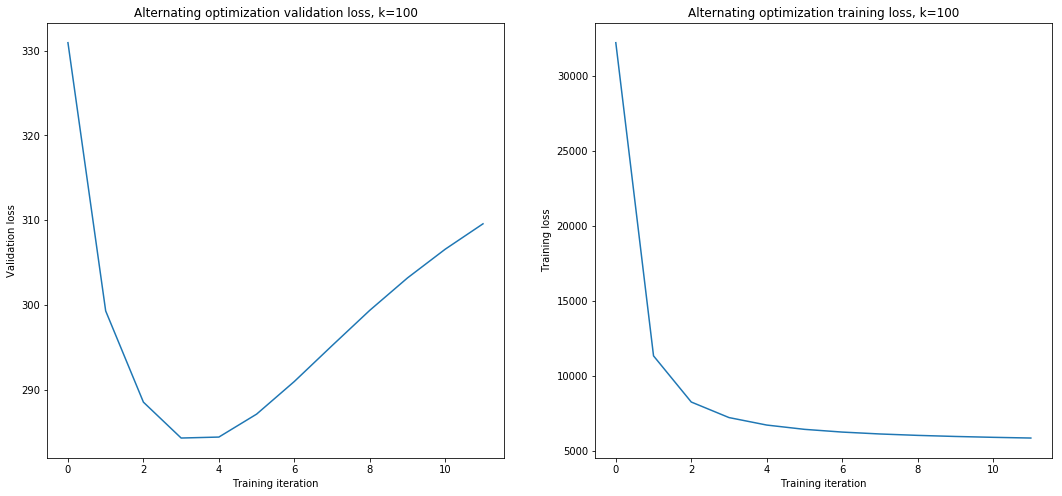

In [15]:
plt.figure(figsize=(18,8))
plt.subplot(1, 2, 1)
x = np.arange(0, len(val_l_a), 1)
plt.plot(x, val_l_a)
plt.title(s='Alternating optimization validation loss, k=100', loc='center')
plt.xlabel(s='Training iteration')
plt.ylabel(s='Validation loss')
plt.xticks(range(0,len(x), 2))

# second plot
plt.subplot(1, 2, 2)
plt.plot(x, tr_l_a)
plt.title(s='Alternating optimization training loss, k=100', loc='center')
plt.xlabel(s='Training iteration')
plt.ylabel(s='Training loss')
plt.xticks(range(0,len(x), 2))
plt.show()

## Latent factorization using gradient descent
We now use gradient descent to factorize our ratings matrix. We will try both (mini-) batch and stochastic gradient descent.

Recall that the objective function (loss) we wanted to optimize was:
$$
\mathcal{L} = \min_{P, Q} \sum_{(x, i) \in W} (r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)^2 + \lambda_1\sum_x{\left\lVert \mathbf{p}_x  \right\rVert}^2 + \lambda_2\sum_i {\left\lVert\mathbf{q}_i  \right\rVert}^2
$$

where $W$ is the set of $(x, i)$ pairs for which $r_{xi}$ is known. Here we have also introduced two regularization terms to help us with overfitting where $\lambda_1$ and $\lambda_2$ are hyper-parameters that control the strength of the regularization.

Naturally optimizing with gradient descent involves computing the gradient of the loss function $\mathcal{L}$ w.r.t. to the parameters.

$$
\frac{\partial ((r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)^2)}{\partial \mathbf{p}_x} = -2(r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)\mathbf{q}_i\;, ~~~
\frac{\partial ((r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)^2)}{\partial \mathbf{q}_i} = -2(r_{xi} - \mathbf{q}_i^T\mathbf{p}_x)\mathbf{p}_x 
$$

$$
\frac{\partial(\lambda_1{\left\lVert \mathbf{p}_x \right\rVert}^2)}{\partial \mathbf{p}_x} = 2 \lambda_1 \mathbf{p_x} \;, ~~~
\frac{\partial(\lambda_2{\left\lVert \mathbf{q}_i \right\rVert}^2)}{\partial \mathbf{q}_i} = 2 \lambda_2 \mathbf{q_i}
$$


In [16]:
def latent_factor_gradient_descent(M, non_zero_idx, k, val_idx, val_values, 
                                   reg_lambda, learning_rate, batch_size=-1,
                                   max_steps=50000, init='random',
                                   log_every=1000, patience=20,
                                   eval_every=50):
    
    #Initialize variables
    Q,P = initialize_Q_P(M, k, init=init)  
    train_losses, validation_losses, time_per_iteration = [], [], []
    best_Q, best_P = Q, P
    best_val = loss_validation(val_values, val_idx, P, Q)
    grad_P, grad_Q = np.zeros_like(P), np.zeros_like(Q)
    converged_after = -1
    min_reached = False
    
    
    # get nonzero rows/cols
    nz_rows_full, nz_cols_full = non_zero_idx[:,0], non_zero_idx[:,1]
    
    # compute scaling factor
    N = non_zero_idx.shape[0]
    if batch_size == -1:
        b_scaling = 1.
    else:
        b_scaling = N/batch_size
    
    start = time.time()
    for iters in range(max_steps):
        if iters % eval_every == 1 or eval_every == 1: start = time.time()
            
        # select batch indices
        if batch_size == -1:
            nz_rows_batch, nz_cols_batch = nz_rows_full, nz_cols_full
        else:
            batch_indices = np.random.choice(N, batch_size, replace=False)
            nz_rows_batch, nz_cols_batch = nz_rows_full[batch_indices], nz_cols_full[batch_indices]
            
        # Get the error matrix
        if batch_size == -1:
            eps = np.asarray(M[nz_rows_batch,nz_cols_batch] - (Q.dot(P))[nz_rows_batch,nz_cols_batch]).flatten()
        else:
            eps = np.asarray(M[nz_rows_batch,nz_cols_batch] - (Q[nz_rows_batch].dot(P[:,nz_cols_batch])).diagonal()).flatten()
        eps_sparse = sp.csr_matrix((eps, (nz_rows_batch,nz_cols_batch)), shape=M.shape)
            
        # Compute the gradient
        grad_P = (b_scaling*2*eps_sparse.T.dot(Q)).T-reg_lambda*P
        grad_Q = b_scaling*2*eps_sparse.dot(P.T)-reg_lambda*Q
        # Perform the update
        P = P + learning_rate*grad_P
        Q = Q + learning_rate*grad_Q

        # evaluation
        if (iters % eval_every) == 0:
            train_losses.append(loss_function(P, Q, M, non_zero_idx))
            validation_losses.append(loss_validation(val_values, val_idx, P, Q))
            end = time.time()
            if iters == 0:
                time_per_iteration.append(end - start)
            else:
                time_per_iteration.append((end - start) / eval_every)
            now_at = int(iters//eval_every)
            if iters > 1 and validation_losses[now_at] < best_val: 
                best_Q, best_P, best_val = Q, P, validation_losses[now_at]
                converged_after = iters
                min_reached = True
            elif min_reached:
                patience -= 1
                
        # logging
        if (iters % log_every) == 0:
            print("Iteration %i,  training loss: %.3f, validation loss: %.3f, time per iteration: %.3f"
                 % (iters, train_losses[-1], validation_losses[-1], time_per_iteration[-1]))
        if patience == 0: break
        if iters == max_steps - 1: converged_after = -1

    # final results
    average_time = np.mean(np.array(time_per_iteration))
    if converged_after == -1:
        converged_after = max_steps
        print("Did not converge in %i iterations, on average %.3f seconds per iteration." % (max_steps, average_time))
    else:
        print("Converged after %d iterations, on average %.3f seconds per iteration." % (converged_after, average_time))

            
    return best_Q, best_P, validation_losses, train_losses, converged_after

In [17]:
Q_g_sweep, P_g_sweep, val_l_g_sweep, tr_l_g_sweep, conv_g_sweep =  latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                                                   k=30, val_idx=val_idx,
                                                                                                   val_values=val_values_shifted, 
                                                                                                   reg_lambda=1e-2, learning_rate=1e-3,
                                                                                                   init='svd', batch_size=-1,
                                                                                                   max_steps=10000, log_every=20, 
                                                                                                   eval_every=20)

Iteration 0,  training loss: 335084.249, validation loss: 268.217, time per iteration: 0.666
Iteration 20,  training loss: 320519.304, validation loss: 267.280, time per iteration: 0.262
Iteration 40,  training loss: 284438.737, validation loss: 262.376, time per iteration: 0.267
Iteration 60,  training loss: 242090.696, validation loss: 258.056, time per iteration: 0.259
Iteration 80,  training loss: 196944.066, validation loss: 262.483, time per iteration: 0.267
Iteration 100,  training loss: 154615.214, validation loss: 272.683, time per iteration: 0.266
Iteration 120,  training loss: 119413.717, validation loss: 283.939, time per iteration: 0.266
Iteration 140,  training loss: 92541.644, validation loss: 294.919, time per iteration: 0.263
Iteration 160,  training loss: 72880.629, validation loss: 305.450, time per iteration: 0.261
Iteration 180,  training loss: 58676.742, validation loss: 315.127, time per iteration: 0.264
Iteration 200,  training loss: 48381.006, validation loss: 

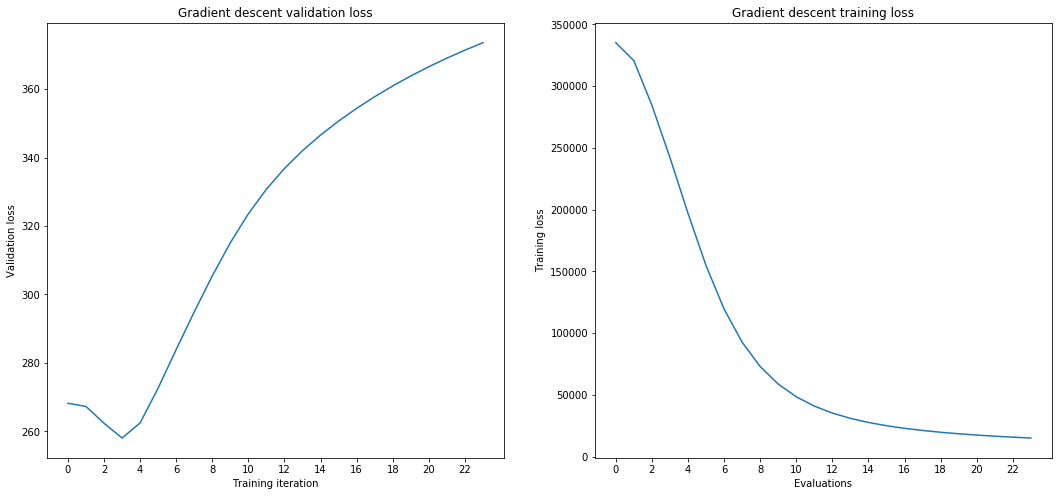

In [18]:
# First plot
plt.figure(figsize=(18,8))
plt.subplot(1, 2, 1)
x = np.arange(0, len(val_l_g_sweep), 1)
plt.plot(x, val_l_g_sweep)
plt.title(s='Gradient descent validation loss', loc='center')
plt.xlabel(s='Training iteration')
plt.ylabel(s='Validation loss')
plt.xticks(range(0,len(x), 2))

# second plot
plt.subplot(1, 2, 2)
plt.plot(x, tr_l_g_sweep)
plt.title(s='Gradient descent training loss', loc='center')
plt.xlabel(s='Evaluations')
plt.ylabel(s='Training loss')
plt.xticks(range(0,len(x), 2))
plt.show()


In [19]:
Q_g_st, P_g_st, val_l_g_st, tr_l_g_st, conv_g_st = latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                                   k=30, val_idx=val_idx,
                                                                                   val_values=val_values_shifted, 
                                                                                   reg_lambda=1e-4, learning_rate=1e-6,
                                                                                   init='svd', batch_size=1,
                                                                                   max_steps=20000, log_every=500, 
                                                                                   eval_every=50)

Iteration 0,  training loss: 335300.036, validation loss: 268.226, time per iteration: 0.425
Iteration 500,  training loss: 335178.715, validation loss: 268.244, time per iteration: 0.022
Iteration 1000,  training loss: 335090.851, validation loss: 268.185, time per iteration: 0.021
Iteration 1500,  training loss: 334997.247, validation loss: 268.199, time per iteration: 0.021
Converged after 900 iterations, on average 0.032 seconds per iteration.


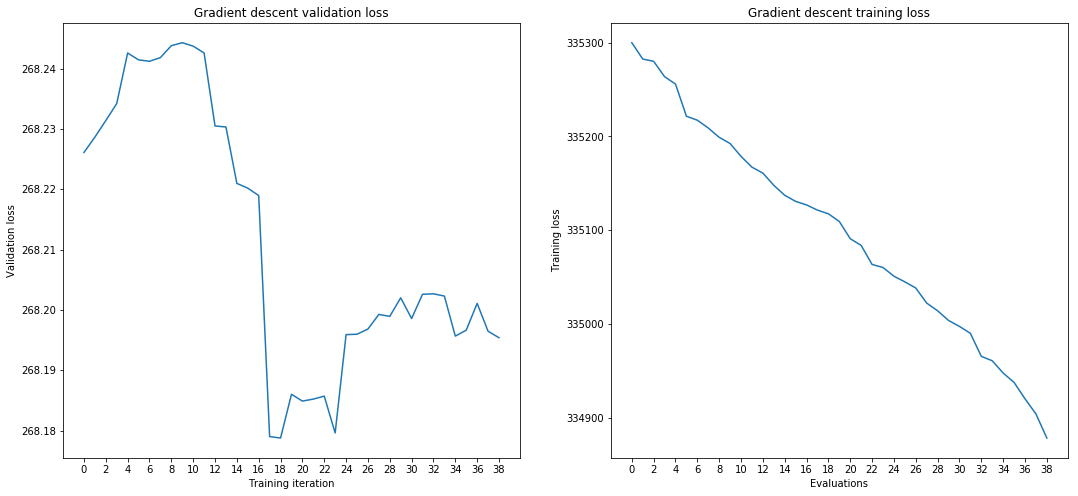

In [20]:
# First plot
plt.figure(figsize=(18,8))
plt.subplot(1, 2, 1)
x = np.arange(0, len(val_l_g_st), 1)
plt.plot(x, val_l_g_st)
plt.title(s='Gradient descent validation loss', loc='center')
plt.xlabel(s='Training iteration')
plt.ylabel(s='Validation loss')
plt.xticks(range(0,len(x), 2))

# second plot
plt.subplot(1, 2, 2)
plt.plot(x, tr_l_g_st)
plt.title(s='Gradient descent training loss', loc='center')
plt.xlabel(s='Evaluations')
plt.ylabel(s='Training loss')
plt.xticks(range(0,len(x), 2))
plt.show()


## Hyperparameter
Machine learning models are often heavily dependent on the hyperparameter settings, e.g. the learning rate. Here, we will try a simple random search to find good values of the latent factor dimension $k$, the batch size, learning rate, and regularization.  

Perform a hyperparameter search to find good values for the batch size, lambda, learning rate, and latent dimension. 

* For the batch size, we evaluate all values in [1, 32, 512, -1] (-1 corresponds to full-sweep gradient descent).
* For $\lambda$, we randomly sample three values in the interval [0, 1).
* For the learning rate, we evaluate all values in [1, 0.1, 0.01].
* For the latent dimension, we uniformly sample three values in the interval [5,30].

We perform an exhaustive search among all combinations of these values.


In [21]:
def parameter_search(M_train, val_idx, val_values):
    #basically the same as for Neural networks
    # Store away the nonzero indices of M before subtracting the row means.
    nonzero_indices = np.vstack((M_train.nonzero()[0], M_train.nonzero()[1])).T

    # Remove user means.
    M_shifted, user_means = shift_user_mean(M_train)

    # Apply the same shift to the validation and test data.
    val_values_shifted = val_values - user_means[val_idx[0]]
    test_values_shifted = test_values - user_means[test_idx[0]]
    
    
    batch_sizes = [1,32,512,-1]
    lam = np.random.rand(3)*1e-2
    lr = [1e-3, 1e-4, 1e-6]
    ld = np.random.randint(low=5, high=31, size=3)
    best_val_loss = -1
    best_conf = {}
    for bs in batch_sizes:
        for l in lam:
            for eta in lr:
                for dim in ld:
                    print("Training with configuration: batch size %i, lambda %f, eta %f, latent dimension %i"%(bs, l, eta, dim))
                    
                    ##Train latent_factor_gradient_descent
                    Q, P, val_loss, tr_loss, conv =  fake_gradient_descent(M_shifted, nonzero_indices, 
                                                                           k=dim, val_idx=val_idx,
                                                                           val_values=val_values_shifted, 
                                                                           reg_lambda=l, learning_rate=eta,
                                                                           init='svd', batch_size=bs,
                                                                           max_steps=10000, log_every=500, 
                                                                           eval_every=20)
                    
                    val_loss_min = min(val_loss)
                    if best_val_loss == -1 or best_val_loss > val_loss_min:
                        best_val_loss = val_loss_min
                        best_conf = {'batch_size':bs, 'lambda':l, 'learning_rate':eta, 'latent_dimension':dim}
                        print("New best configuration with loss %f"%val_loss_min)
                    print("\n")
                        
        
    print("Best configuration is {}").format(best_conf)
    return best_conf

In [ ]:
best_configuration = parameter_search(M_train, val_idx, val_values)

In [22]:
bbs = best_configuration['batch_size']
blmbd = best_configuration['lambda']
blr = best_configuration['learning_rate']
bld = best_configuration['latent_dimension']
print("Best batch size: %i\nBest lambda: %f\nBest learning rate: %f\nBest latent dimension: %i"%(bbs, blmbd, blr, bld))

NameError: name 'best_configuration' is not defined

## Comparison of gradient descent and alternating optimization



In [23]:
def rmse(P,Q,M,non_zero_idx):
    return np.sqrt(np.mean(np.array(M[non_zero_idx[:,0], non_zero_idx[:,1]]-(Q.dot(P))[non_zero_idx[:,0], non_zero_idx[:,1]])**2))

def rmse_val(val_values, val_idx, P, Q):
    return np.sqrt(np.mean(np.array(val_values-(Q.dot(P))[val_idx[0], val_idx[1]])**2))

In [24]:
# Finding the best k for gradient descent
k_values = [25, 50, 100, 150]
best_val_loss = -1
best_GD_conf = {}
for k in k_values:
    print("Training gradient descent with k = %i"%(k))
                    
    ##Train latent_factor_gradient_descent
    Q, P, val_loss, tr_loss, conv =  latent_factor_gradient_descent(M_shifted, nonzero_indices, 
                                                                    k=k, val_idx=val_idx,
                                                                    val_values=val_values_shifted, 
                                                                    reg_lambda=1e-2, learning_rate=1e-3,
                                                                    init='svd', batch_size=-1,
                                                                    max_steps=5000, log_every=1000, 
                                                                    eval_every=20)
                    
    val_loss_min = min(val_loss)
    if best_val_loss == -1 or best_val_loss > val_loss_min:
        best_val_loss = val_loss_min
        best_GD_conf = {'k':k, 'Q':Q, 'P':P}
        print("New best configuration with loss %f"%val_loss_min)
    print("\n")

Training gradient descent with k = 25
Iteration 0,  training loss: 335368.179, validation loss: 268.238, time per iteration: 0.557
Converged after 60 iterations, on average 0.263 seconds per iteration.
New best configuration with loss 259.824325


Training gradient descent with k = 50
Iteration 0,  training loss: 334006.007, validation loss: 268.215, time per iteration: 0.673
Converged after 60 iterations, on average 0.305 seconds per iteration.


Training gradient descent with k = 100
Iteration 0,  training loss: 331564.106, validation loss: 268.254, time per iteration: 0.792
Converged after 60 iterations, on average 0.361 seconds per iteration.


Training gradient descent with k = 150
Iteration 0,  training loss: 329367.886, validation loss: 268.280, time per iteration: 0.828
Converged after 40 iterations, on average 0.397 seconds per iteration.




In [25]:
# Print the error of the best GD configuration
Q_GD, P_GD = best_GD_conf['Q'], best_GD_conf['P']
train_err = rmse(P_GD, Q_GD, M_shifted, nonzero_indices)
val_err = rmse_val(val_values_shifted, val_idx, P_GD, Q_GD)
test_err = rmse_val(test_values_shifted, test_idx, P_GD, Q_GD)
print("Training RMSE of best gradient descent model: %f"%train_err)
print("Validation RMSE of best gradient descent model: %f"%val_err)
print("Test RMSE of best gradient descent model: %f"%test_err)

Training RMSE of best gradient descent model: 0.937262
Validation RMSE of best gradient descent model: 1.139790
Test RMSE of best gradient descent model: 1.086432


In [26]:
# Finding the best k for alternating optimization
k_values = [25, 50, 100, 150]
best_val_loss = -1
best_AO_conf = {}
for k in k_values:
    print("Training alternating optimization with k = %i"%(k))
                    
    ##Train latent_factor_gradient_descent
    Q, P, val_loss, tr_loss, conv  = latent_factor_alternating_optimization(M_shifted, nonzero_indices, 
                                                                            k=k, val_idx=val_idx,
                                                                            val_values=val_values_shifted, 
                                                                            reg_lambda=1, init='random',
                                                                            max_steps=100, patience=10)
                    
    val_loss_min = min(val_loss)
    if best_val_loss == -1 or best_val_loss > val_loss_min:
        best_val_loss = val_loss_min
        best_AO_conf = {'k':k, 'Q':Q, 'P':P}
        print("New best configuration with loss %f"%val_loss_min)
    print("\n")

Training alternating optimization with k = 25
Iteration 0,  training loss: 125260.792, validation loss: 331.192
Iteration 1,  training loss: 76328.114, validation loss: 375.364
Iteration 2,  training loss: 60256.452, validation loss: 386.986
Iteration 3,  training loss: 52038.227, validation loss: 397.562
Iteration 4,  training loss: 47003.619, validation loss: 407.637
Iteration 5,  training loss: 43606.925, validation loss: 414.838
Iteration 6,  training loss: 41150.426, validation loss: 419.601
Iteration 7,  training loss: 39281.411, validation loss: 424.368
Iteration 8,  training loss: 37802.098, validation loss: 430.753
Iteration 9,  training loss: 36593.278, validation loss: 438.534
Iteration 10,  training loss: 35583.760, validation loss: 447.000
Converged after 2 iterations, on average 22.68 seconds per iteration.
New best configuration with loss 331.191522


Training alternating optimization with k = 50
Iteration 0,  training loss: 67216.829, validation loss: 351.832
Iteration 

In [27]:
# Print the error of the best AO configuration
Q_AO, P_AO = best_AO_conf['Q'], best_AO_conf['P']
train_err = rmse(P_AO, Q_AO, M_shifted, nonzero_indices)
val_err = rmse_val(val_values_shifted, val_idx, P_AO, Q_AO)
test_err = rmse_val(test_values_shifted, test_idx, P_AO, Q_AO)
print("Training RMSE of best alternating optimization model: %f"%train_err)
print("Validation RMSE of best alternating optimization model: %f"%val_err)
print("Test RMSE of best alternating optimization model: %f"%test_err)

Training RMSE of best alternating optimization model: 0.143585
Validation RMSE of best alternating optimization model: 1.244094
Test RMSE of best alternating optimization model: 1.247788


### Plot pred. vs ground truth

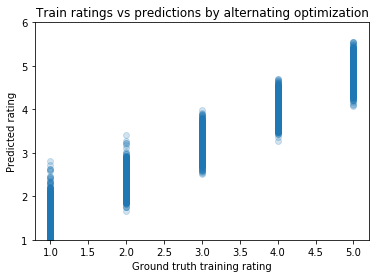

In [28]:
# user means have to be added to retrieve original values
M_pred_AO = Q_AO.dot(P_AO) + np.matrix(user_means).T
plt.scatter(np.asarray(M[nonzero_indices[:,0], nonzero_indices[:,1]]).flatten(), np.asarray(M_pred_AO[nonzero_indices[:,0], nonzero_indices[:,1]]).flatten(), alpha=0.2)
plt.xlabel(s="Ground truth training rating")
plt.ylabel(s="Predicted rating")
plt.title("Train ratings vs predictions by alternating optimization", loc='center')
plt.ylim([1,6])
plt.show()

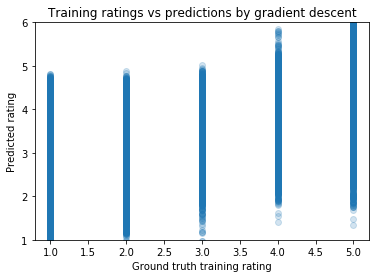

In [29]:
M_pred_GD = Q_GD.dot(P_GD) + np.matrix(user_means).T
plt.scatter(np.asarray(M[nonzero_indices[:,0], nonzero_indices[:,1]]).flatten(), np.asarray(M_pred_GD[nonzero_indices[:,0], nonzero_indices[:,1]]).flatten(), alpha=0.2)
plt.xlabel(s="Ground truth training rating")
plt.ylabel(s="Predicted rating")
plt.title("Training ratings vs predictions by gradient descent", loc='center')
plt.ylim([1,6])
plt.show()

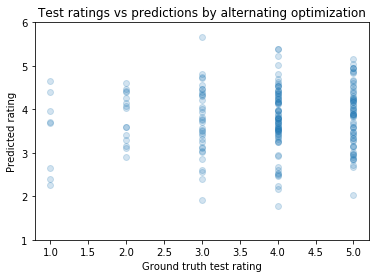

In [30]:
M_pred_AO = Q_AO.dot(P_AO) + np.matrix(user_means).T
plt.scatter(test_values, np.asarray(M_pred_AO[test_idx]).flatten(), alpha=0.2)
plt.xlabel(s="Ground truth test rating")
plt.ylabel(s="Predicted rating")
plt.title("Test ratings vs predictions by alternating optimization", loc='center')
plt.ylim([1,6])
plt.show()

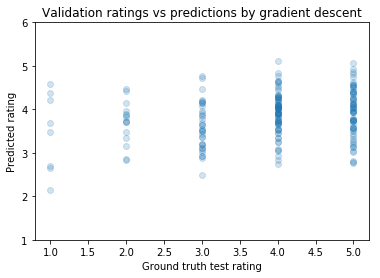

In [31]:
M_pred_GD = Q_GD.dot(P_GD) + np.matrix(user_means).T
plt.scatter(test_values, np.asarray(M_pred_GD[test_idx]).flatten(), alpha=0.2)
plt.xlabel(s="Ground truth test rating")
plt.ylabel(s="Predicted rating")
plt.title("Validation ratings vs predictions by gradient descent", loc='center')
plt.ylim([1,6])
plt.show()